In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
COLORS = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)

In [2]:
df = pd.read_csv("dataset.csv")
x1 = np.array(df["x1"])
x2 = np.array(df["x2"])
x3 = np.array(df["x3"])
X = np.concatenate([x1[:, None], x2[:, None], x3[:, None]], axis=1)
y = np.array(df["y"]).reshape(-1, 1)

print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (1000, 3)
y.shape: (1000, 1)


In [3]:
def tDistributionLogLikelihood(c, X, y):
    """
    Considering t-distribution for noise, the likelihood function is given by:
    L(c) = prod(1 / (1 + (y - Xc)^2))
    The log-likelihood is:
    logL(c) = -sum(log((1 + (y - Xc)^2)))

    Parameters
    ----------
    c : np.ndarray
        The coefficients of the linear model.
    X : np.ndarray
        The input features.
    y : np.ndarray
        The target values.
    
    Returns
    -------
    float
        The likelihood value.
    """

    y_pred = X @ c
    return -np.sum(np.log(1 + (y - y_pred) ** 2))

In [4]:
def derivativeTDistributionLogLikelihood(c, X, y):
    """
    Considering t-distribution for noise, the derivative of the likelihood function is given by:
    dlogL(c) = -2 * sum((y - Xc) * X / (1 + (y - Xc)^2))

    Parameters
    ----------
    c : np.ndarray
        The coefficients of the linear model.
    X : np.ndarray
        The input features.
    y : np.ndarray
        The target values.
    
    Returns
    -------
    np.ndarray
        The derivative of the likelihood function.
    """

    y_pred = X @ c
    return np.sum(2 * (y - y_pred) * X / (1 + (y - y_pred) ** 2), axis=0).reshape(-1, 1)

In [5]:
def gradientDescent(objective, gradient, starting_point, tolerance, max_iterations=10000, learning_rate=1):
    """
    Gradient descent optimization algorithm.

    Parameters
    ----------
    objective : function
        The objective function.
    gradient : function
        The gradient of the objective function.
    starting_point : np.ndarray
        The starting point for the optimization.
    tolerance : float
        The tolerance value for the optimization.
    max_iterations : int
        The maximum number of iterations.
    learning_rate : float
        The learning rate for the optimization.
    
    Returns
    -------
    np.ndarray
        The optimized point.
    """

    c = starting_point
    for i in range(max_iterations):
        grad = gradient(c)
        c = c - learning_rate*grad
        print("\rIteration: {0}, Objective: {1}, Grad: {2}".format(i, objective(c), np.linalg.norm(grad)), end="")

        if np.linalg.norm(grad) < tolerance:
            break
    
    return c

In [6]:
objective_ = lambda c: -tDistributionLogLikelihood(c, X, y)
gradient_ = lambda c: -derivativeTDistributionLogLikelihood(c, X, y)

In [7]:
optimized_c = gradientDescent(objective_, gradient_, np.zeros((X.shape[1], 1)), 50, max_iterations=1000000, learning_rate=5e-10)

Iteration: 999999, Objective: 4251.29745847499, Grad: 168.8595871640107546

In [8]:
def sumofSquaresObjective(c, X, y):
    """
    The sum of squares objective function.

    Parameters
    ----------
    c : np.ndarray
        The coefficients of the linear model.
    X : np.ndarray
        The input features.
    y : np.ndarray
        The target values.
    
    Returns
    -------
    float
        The sum of squares value.
    """

    y_pred = X @ c
    return np.sum((y - y_pred) ** 2)

In [9]:
def derivativeofSumofSquaresObjective(c, X, y):
    """
    The derivative of the sum of squares objective function.

    Parameters
    ----------
    c : np.ndarray
        The coefficients of the linear model.
    X : np.ndarray
        The input features.
    y : np.ndarray
        The target values.
    
    Returns
    -------
    np.ndarray
        The derivative of the sum of squares value.
    """

    y_pred = X @ c
    return -2 * np.sum((y - y_pred) * X, axis=0).reshape(-1, 1)

In [10]:
def derivativeofpredictionFunction(c, X):
    """
    The derivative of the prediction function.

    Parameters
    ----------
    c : np.ndarray
        The coefficients of the linear model.
    X : np.ndarray
        The input features.
    
    Returns
    -------
    np.ndarray
        The derivative of the prediction function.
    """

    return X

In [11]:
def gaussNewton(predFunction, derivativeFunctioon, y, starting_point, tolerance, max_iterations=10000):
    """
    Gauss-Newton optimization algorithm.

    Parameters
    ----------
    predFunction : function
        The prediction function.
    derivativeFunctioon : function
        The derivative of the prediction function.
    y : np.ndarray
        The target values.
    starting_point : np.ndarray
        The starting point for the optimization.
    tolerance : float
        The tolerance value for the optimization.
    max_iterations : int
        The maximum number of iterations.
    
    Returns
    -------
    np.ndarray
        The optimized point.
    float
        The objective value.
    """

    c = starting_point
    objective_ = lambda c: np.sum((y - predFunction(c)) ** 2)
    
    for i in range(max_iterations):
        if np.linalg.norm(derivativeFunctioon(c)) < tolerance:
            break

        pred = predFunction(c)
        jacobian = derivativeFunctioon(c)
        delta_x = np.linalg.inv(jacobian.T @ jacobian) @ jacobian.T @ (y - pred)
        c = c + delta_x

    return c

In [12]:
jacobian_ = lambda c: derivativeofpredictionFunction(c, X)
predFunction_ = lambda c: X @ c

In [13]:
optimized_c_gauss_newton = gaussNewton(predFunction_, jacobian_, y, np.zeros((X.shape[1], 1)), 1e-6)

In [14]:
optimized_c, optimized_c_gauss_newton

(array([[ 0.06510713],
        [ 0.06609702],
        [-0.00583908]]),
 array([[4.998457  ],
        [8.99746165],
        [2.99910356]]))

In [15]:
# This quantity need to be mnimised
sumofSquaresObjective(optimized_c, X, y), sumofSquaresObjective(optimized_c_gauss_newton, X, y)

(517957.787138148, 10.025657838372464)

In [16]:
# This quantity need to be maximised
tDistributionLogLikelihood(optimized_c, X, y), tDistributionLogLikelihood(optimized_c_gauss_newton, X, y)

(-4251.29745847499, -9.880993372136471)

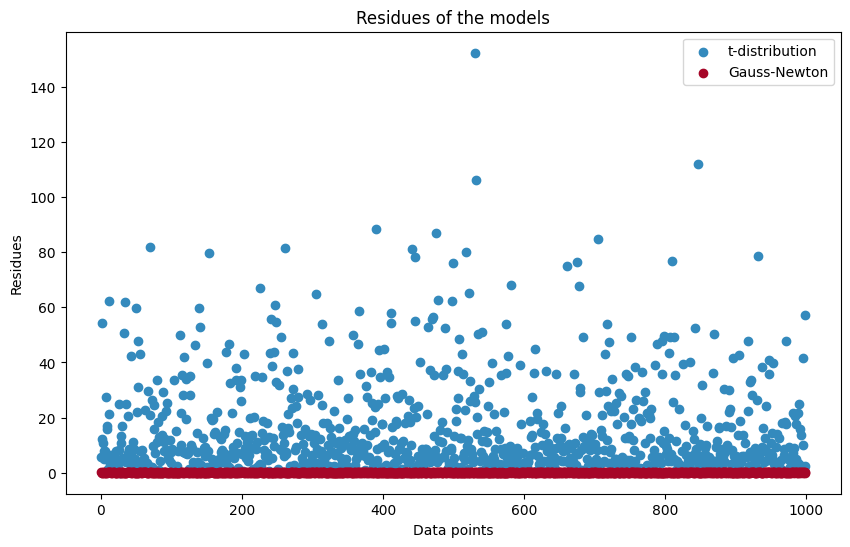

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(range(y.shape[0]), np.abs(y - X @ optimized_c), label="t-distribution")
plt.scatter(range(y.shape[0]), np.abs(y - X @ optimized_c_gauss_newton), label="Gauss-Newton")
plt.xlabel("Data points")
plt.ylabel("Residues")
plt.title("Residues of the models")
plt.legend()
plt.show()

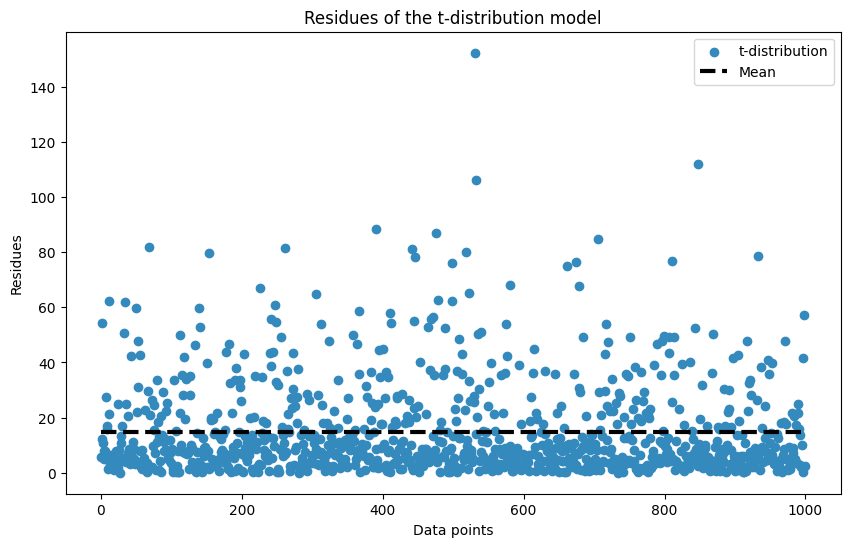

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(range(y.shape[0]), np.abs(y - X @ optimized_c), label="t-distribution")
plt.hlines(np.mean(np.abs(y - X @ optimized_c)), 0, y.shape[0], color="black", linestyle="--", linewidth=3, label="Mean")
plt.xlabel("Data points")
plt.ylabel("Residues")
plt.title("Residues of the t-distribution model")
plt.legend()
plt.show()

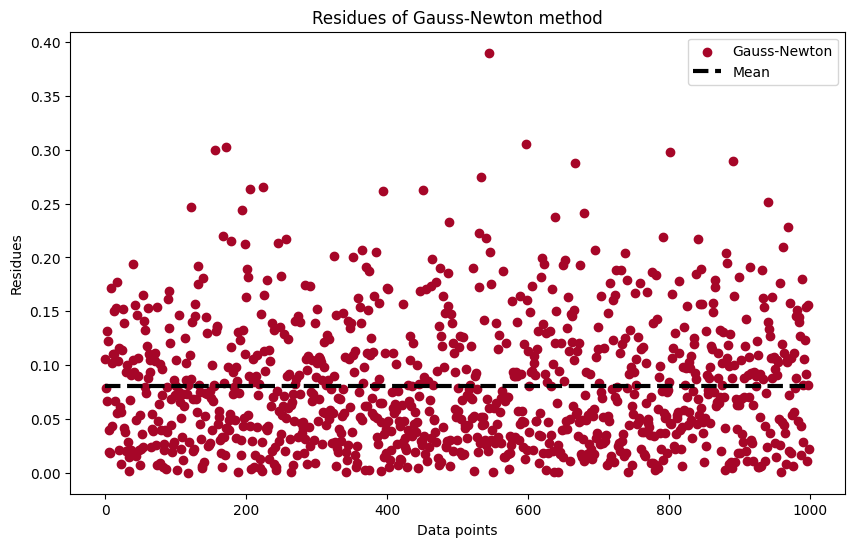

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(range(y.shape[0]), np.abs(y - X @ optimized_c_gauss_newton), label="Gauss-Newton", color=COLORS[1])
plt.hlines(np.mean(np.abs(y - X @ optimized_c_gauss_newton)), 0, y.shape[0], color="black", linestyle="--", linewidth=3, label="Mean")
plt.xlabel("Data points")
plt.ylabel("Residues")
plt.title("Residues of Gauss-Newton method")
plt.legend()
plt.show()

This shows that T-Distriubtion was not a good choice for this problem. If we would have taken Gaussian distribution for the noise then it would have given the same result as the one given by the Sum of Squares of the residuals. Thus, modelling the noise as Gaussian would have been a better choice.